# Biomedical Image Analysis

In [35]:
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from keras.models import Model, load_model
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Dense
from keras.optimizers import Adam
from keras.optimizers import Adagrad
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
def load_normal(norm_path):
    norm_files = np.array(os.listdir(norm_path))
    norm_labels = np.array(['normal']*len(norm_files))
    
    norm_images = []
    for image in tqdm(norm_files):
        image = cv2.imread(norm_path + image)
        image = cv2.resize(image, dsize=(200,200))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        norm_images.append(image)
        
    norm_images = np.array(norm_images)
    print(len(norm_images))
    
    return norm_images, norm_labels
def load_pneumonia(pneu_path):
    pneu_files = np.array(os.listdir(pneu_path))
    pneu_labels = np.array([pneu_file.split('_')[1] for pneu_file in pneu_files])
    
    pneu_images = []
    for image in tqdm(pneu_files):
        image = cv2.imread(pneu_path + image)
        image = cv2.resize(image, dsize=(200,200))
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        pneu_images.append(image)
        
    pneu_images = np.array(pneu_images)
    X_train = np.append(norm_images, pneu_images, axis=0)
    y_train = np.append(norm_labels, pneu_labels)
    
    return pneu_images, pneu_labels

In [4]:
norm_images, norm_labels = load_normal('/Users/marko/Downloads/chest_xray/train/NORMAL/')
pneu_images, pneu_labels = load_pneumonia('/Users/marko/Downloads/chest_xray/train/PNEUMONIA/')

100%|██████████| 1341/1341 [00:14<00:00, 92.90it/s] 


1341


100%|██████████| 3875/3875 [00:12<00:00, 313.15it/s]


In [5]:
X_train = np.append(norm_images, pneu_images, axis=0)
y_train = np.append(norm_labels, pneu_labels)

In [6]:
def plot_images(X, y):
    fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(16, 4))

    indices = np.random.choice(len(X), 14)
    counter = 0

    for i in range(2):
        for j in range(7):
            axes[i,j].set_title(y[indices[counter]])
            axes[i,j].imshow(X[indices[counter]], cmap='gray')
            axes[i,j].get_xaxis().set_visible(False)
            axes[i,j].get_yaxis().set_visible(False)
            counter += 1
    plt.show()

In [8]:
norm_images_test, norm_labels_test = load_normal('/Users/marko/Downloads/chest_xray/test/NORMAL/')
pneu_images_test, pneu_labels_test = load_pneumonia('/Users/marko/Downloads/chest_xray/test/PNEUMONIA/')

100%|██████████| 234/234 [00:01<00:00, 130.37it/s]


234


100%|██████████| 390/390 [00:01<00:00, 347.12it/s]


In [9]:
X_test = np.append(norm_images_test, pneu_images_test, axis=0)
y_test = np.append(norm_labels_test, pneu_labels_test)

In [10]:
with open('pneumonia_data.pickle', 'wb') as f:
    pickle.dump((X_train, X_test, y_train, y_test), f)# Use this to load variables
with open('pneumonia_data.pickle', 'rb') as f:
    (X_train, X_test, y_train, y_test) = pickle.load(f)

In [11]:
np.unique(y_train, return_counts=True)

(array(['bacteria', 'normal', 'virus'], dtype='<U8'),
 array([2530, 1341, 1345]))

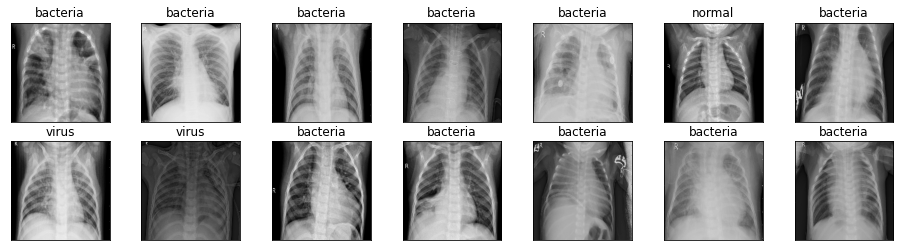

In [12]:
plot_images(X_train, y_train)

In [13]:
np.unique(y_train, return_counts=True)

(array(['bacteria', 'normal', 'virus'], dtype='<U8'),
 array([2530, 1341, 1345]))

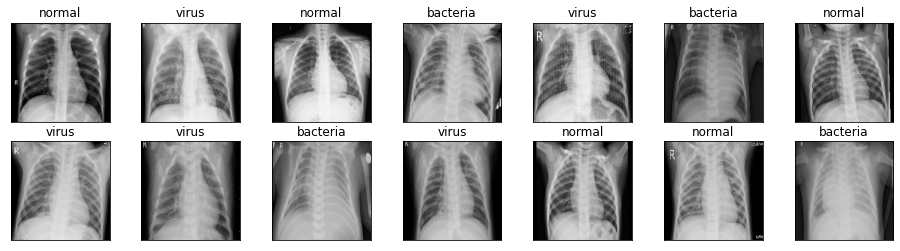

In [14]:
plot_images(X_test, y_test)

In [15]:
y_train = y_train[:, np.newaxis]
y_test = y_test[:, np.newaxis]
y_train

array([['normal'],
       ['normal'],
       ['normal'],
       ...,
       ['virus'],
       ['virus'],
       ['virus']], dtype='<U8')

In [16]:
y_test

array([['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['nor

In [17]:
one_hot_encoder = OneHotEncoder(sparse=False, handle_unknown = 'error')

In [18]:
y_train_one_hot = one_hot_encoder.fit_transform(y_train)
y_test_one_hot = one_hot_encoder.transform(y_test)

/Users/marko/opt/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [19]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [20]:
datagen = ImageDataGenerator(
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

In [21]:
datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train_one_hot, batch_size=32)

In [22]:
input1 = Input(shape=(X_train.shape[1], X_train.shape[2], 1))

cnn = Conv2D(16, (3, 3), activation='sigmoid', strides=(1, 1), 
    padding='same')(input1)
cnn = Conv2D(32, (3, 3), activation='sigmoid', strides=(1, 1), 
    padding='same')(cnn)
cnn = MaxPool2D((2, 2))(cnn)

cnn = Conv2D(16, (2, 2), activation='sigmoid', strides=(1, 1), 
    padding='same')(cnn)
cnn = Conv2D(32, (2, 2), activation='sigmoid', strides=(1, 1), 
    padding='same')(cnn)
cnn = MaxPool2D((2, 2))(cnn)

cnn = Flatten()(cnn)
cnn = Dense(100, activation='relu')(cnn)
cnn = Dense(50, activation='relu')(cnn)
output1 = Dense(3, activation='softmax')(cnn)

model = Model(inputs=input1, outputs=output1)

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 16)      2064      
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 32)      2080      
                                                             

In [24]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [25]:
history2 = model.fit_generator(train_gen, epochs=30, validation_data=(X_test, y_test_one_hot))

Epoch 1/30


<ipython-input-25-b2e474c5510d>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model.fit_generator(train_gen, epochs=30, validation_data=(X_test, y_test_one_hot))


NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_12' defined at (most recent call last):
    File "/Users/marko/opt/miniconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/marko/opt/miniconda3/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/marko/opt/miniconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/Users/marko/opt/miniconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/Users/marko/opt/miniconda3/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 619, in start
      self.io_loop.start()
    File "/Users/marko/opt/miniconda3/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/Users/marko/opt/miniconda3/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/Users/marko/opt/miniconda3/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/Users/marko/opt/miniconda3/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/marko/opt/miniconda3/lib/python3.9/site-packages/tornado/ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/Users/marko/opt/miniconda3/lib/python3.9/site-packages/tornado/ioloop.py", line 741, in _run_callback
      ret = callback()
    File "/Users/marko/opt/miniconda3/lib/python3.9/site-packages/tornado/gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "/Users/marko/opt/miniconda3/lib/python3.9/site-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/Users/marko/opt/miniconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 358, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/Users/marko/opt/miniconda3/lib/python3.9/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/marko/opt/miniconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/Users/marko/opt/miniconda3/lib/python3.9/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/marko/opt/miniconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 536, in execute_request
      self.do_execute(
    File "/Users/marko/opt/miniconda3/lib/python3.9/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/marko/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 302, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/Users/marko/opt/miniconda3/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 539, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/Users/marko/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/Users/marko/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/Users/marko/opt/miniconda3/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/marko/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/marko/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/marko/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-25-b2e474c5510d>", line 1, in <module>
      history2 = model.fit_generator(train_gen, epochs=30, validation_data=(X_test, y_test_one_hot))
    File "/Users/marko/opt/miniconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2604, in fit_generator
      return self.fit(
    File "/Users/marko/opt/miniconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/marko/opt/miniconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/marko/opt/miniconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/Users/marko/opt/miniconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/marko/opt/miniconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/Users/marko/opt/miniconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/Users/marko/opt/miniconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/Users/marko/opt/miniconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/Users/marko/opt/miniconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/Users/marko/opt/miniconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/Users/marko/opt/miniconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/Users/marko/opt/miniconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_12'
could not find registered platform with id: 0x170f6a7c0
	 [[{{node StatefulPartitionedCall_12}}]] [Op:__inference_train_function_1716]

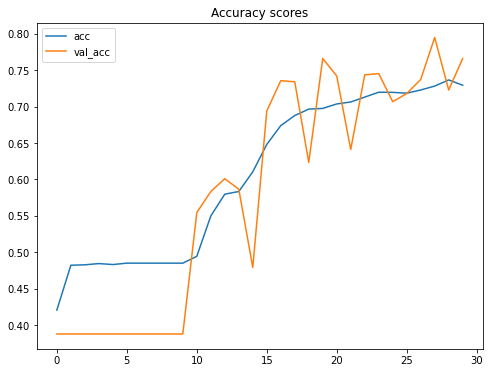

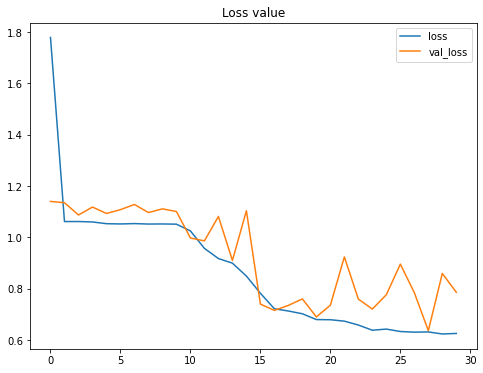

In [144]:
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.show()
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [26]:
X_train, X_test, y_train_one_hot, y_test_one_hot = train_test_split(
  X_train, y_train_one_hot, test_size=0.2, random_state = 42)

In [27]:
vgg16 = VGG16(weights='imagenet', include_top=False)
hdf5_save = 'VGG16_Model.hdf5'
annealer = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.70, patience=5,
    verbose=1, min_lr=1e-4)
  
checkpoint = ModelCheckpoint(hdf5_save, verbose=1, save_best_only=True)
  
datagen2 = ImageDataGenerator(rotation_range=360,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True)
datagen2.fit(X_train)
train_gen2 = datagen.flow(X_train, y_train_one_hot, batch_size=32)



input = Input(shape=(X_train.shape[1], X_train.shape[2], 1))
x = Conv2D(3, (3, 3), padding='same')(input)

x = vgg16(x)
  
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(200, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

output = Dense(3, activation='softmax', name='root')(x)
model2 = Model(input, output)
  
optimizer = Adam(lr=0.003, beta_1=0.9, beta_2=0.999,
                     epsilon=0.1, decay=0.0)
      
model2.compile(loss='categorical_crossentropy',
                  optimizer=optimizer, metrics=['accuracy'])
      
model2.summary()
    
history = model2.fit_generator(train_gen2, epochs=30, validation_data=(X_test, y_test_one_hot))


58889256/58889256 [==============================] - 6s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 200, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 200, 200, 3)       30        
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                            

/Users/marko/opt/miniconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
<ipython-input-27-40bc877d401a>:43: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model2.fit_generator(train_gen2, epochs=30, validation_data=(X_test, y_test_one_hot))


131/131 [==============================] - 329s 3s/step - loss: 1.1410 - accuracy: 0.5384 - val_loss: 2.6226 - val_accuracy: 0.3908
Epoch 2/30
131/131 [==============================] - 327s 2s/step - loss: 0.8542 - accuracy: 0.6210 - val_loss: 1.8998 - val_accuracy: 0.5450
Epoch 3/30
131/131 [==============================] - 317s 2s/step - loss: 0.7991 - accuracy: 0.6393 - val_loss: 0.7455 - val_accuracy: 0.6561
Epoch 4/30
131/131 [==============================] - 237s 2s/step - loss: 0.7515 - accuracy: 0.6474 - val_loss: 0.8664 - val_accuracy: 0.5096
Epoch 5/30
131/131 [==============================] - 240s 2s/step - loss: 0.7152 - accuracy: 0.6733 - val_loss: 2.0276 - val_accuracy: 0.3008
Epoch 6/30
131/131 [==============================] - 236s 2s/step - loss: 0.6659 - accuracy: 0.6963 - val_loss: 1.5768 - val_accuracy: 0.3046
Epoch 7/30
131/131 [==============================] - 239s 2s/step - loss: 0.6246 - accuracy: 0.7246 - val_loss: 2.1402 - val_accuracy: 0.4234
Epoch 8/30

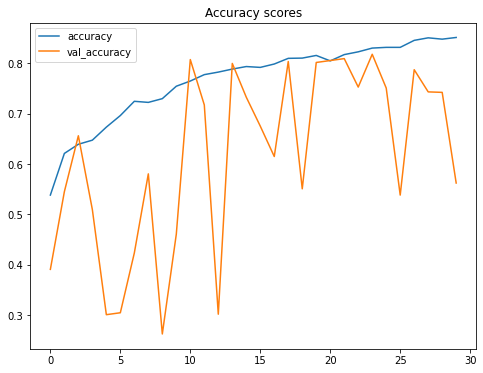

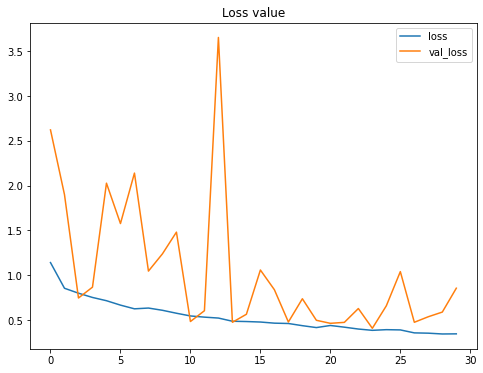

In [28]:
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [36]:
input3 = Input(shape=(X_train.shape[1], X_train.shape[2], 1))

cnn2 = Conv2D(8, (3, 3), activation='tanh', strides=(1, 1), 
    padding='same')(input3)
cnn2 = Conv2D(16, (3, 3), activation='tanh', strides=(1, 1), 
    padding='same')(cnn2)
cnn2 = MaxPool2D((2, 2))(cnn2)

cnn2 = Conv2D(16, (2, 2), activation='tanh', strides=(1, 1), 
    padding='same')(cnn2)
cnn2 = Conv2D(32, (2, 2), activation='tanh', strides=(1, 1), 
    padding='same')(cnn2)
cnn2 = MaxPool2D((2, 2))(cnn2)

cnn2 = Flatten()(cnn2)
cnn2 = Dense(50, activation='relu')(cnn2)
cnn2 = Dense(25, activation='relu')(cnn2)
output3 = Dense(3, activation='softmax')(cnn2)

model3 = Model(inputs=input3, outputs=output3)

optimizer2 = Adagrad(learning_rate=0.01, initial_accumulator_value=0.1, epsilon=1e-07)
      
model3.compile(loss='categorical_crossentropy',
                  optimizer=optimizer2, metrics=['accuracy'])
      
model3.summary()
    
history2 = model3.fit_generator(train_gen, epochs=20, validation_data=(X_test, y_test_one_hot))

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 200, 200, 1)]     0         
                                                                 
 conv2d_29 (Conv2D)          (None, 200, 200, 8)       80        
                                                                 
 conv2d_30 (Conv2D)          (None, 200, 200, 16)      1168      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 100, 100, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 100, 100, 16)      1040      
                                                                 
 conv2d_32 (Conv2D)          (None, 100, 100, 32)      2080      
                                                           

<ipython-input-36-0585672046e2>:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model3.fit_generator(train_gen, epochs=20, validation_data=(X_test, y_test_one_hot))


163/163 [==============================] - 18s 102ms/step - loss: 1.7750 - accuracy: 0.5167 - val_loss: 0.7745 - val_accuracy: 0.6619
Epoch 2/20
163/163 [==============================] - 16s 100ms/step - loss: 0.7631 - accuracy: 0.6670 - val_loss: 0.7909 - val_accuracy: 0.6446
Epoch 3/20
163/163 [==============================] - 17s 101ms/step - loss: 0.6687 - accuracy: 0.7082 - val_loss: 0.5800 - val_accuracy: 0.7462
Epoch 4/20
163/163 [==============================] - 16s 99ms/step - loss: 0.6386 - accuracy: 0.7312 - val_loss: 0.5476 - val_accuracy: 0.7768
Epoch 5/20
163/163 [==============================] - 16s 99ms/step - loss: 0.6154 - accuracy: 0.7412 - val_loss: 0.5686 - val_accuracy: 0.7596
Epoch 6/20
163/163 [==============================] - 16s 99ms/step - loss: 0.6053 - accuracy: 0.7467 - val_loss: 0.5499 - val_accuracy: 0.7510
Epoch 7/20
163/163 [==============================] - 16s 99ms/step - loss: 0.5993 - accuracy: 0.7523 - val_loss: 0.5555 - val_accuracy: 0.7529


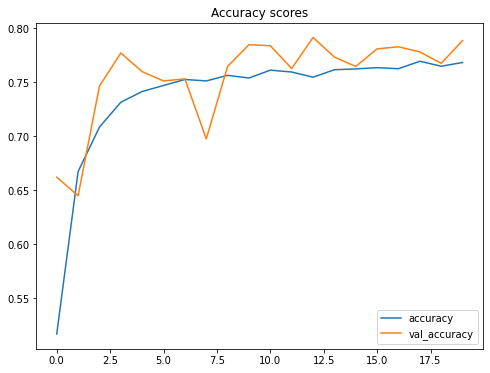

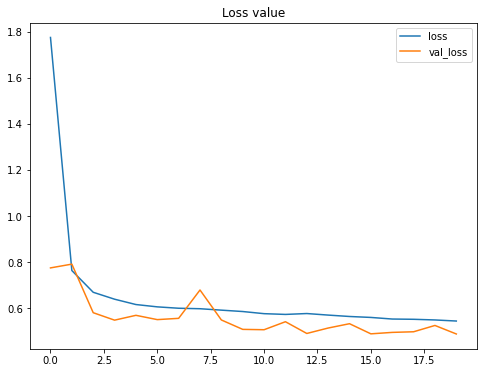

In [38]:
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()